In [2]:
# util

import torch
import shutil

def save_checkpoint(save_path, dispnet_state, exp_pose_state, is_best, filename='checkpoint.pth.tar'):
    file_prefixes = ['dispnet', 'exp_pose']
    states = [dispnet_state, exp_pose_state]
    for (prefix, state) in zip(file_prefixes, states):
        torch.save(state, save_path/'{}_{}'.format(prefix, filename))

    if is_best:
        for prefix in file_prefixes:
            shutil.copyfile(save_path/'{}_{}'.format(prefix, filename),
                            save_path/'{}_model_best.pth.tar'.format(prefix))


In [3]:

import argparse

parser = argparse.ArgumentParser(description='Structure from Motion Learner training on KITTI and CityScapes Dataset',
                                 formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument('data', metavar='DIR', default='/', help='path to dataset')
parser.add_argument('--folder-type', type=str, choices=['sequence', 'pair'], default='sequence', help='the dataset dype to train')
parser.add_argument('--sequence-length', type=int, metavar='N', help='sequence length for training', default=3)
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N', help='number of data loading workers')
parser.add_argument('--epochs', default=200, type=int, metavar='N', help='number of total epochs to run')
parser.add_argument('--epoch-size', default=0, type=int, metavar='N', help='manual epoch size (will match dataset size if not set)')
parser.add_argument('-b', '--batch-size', default=4, type=int, metavar='N', help='mini-batch size')
parser.add_argument('--lr', '--learning-rate', default=1e-4, type=float, metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M', help='momentum for sgd, alpha parameter for adam')
parser.add_argument('--beta', default=0.999, type=float, metavar='M', help='beta parameters for adam')
parser.add_argument('--weight-decay', '--wd', default=0, type=float, metavar='W', help='weight decay')
parser.add_argument('--print-freq', default=10, type=int, metavar='N', help='print frequency')
parser.add_argument('--seed', default=0, type=int, help='seed for random functions, and network initialization')
parser.add_argument('--log-summary', default='progress_log_summary.csv', metavar='PATH', help='csv where to save per-epoch train and valid stats')
parser.add_argument('--log-full', default='progress_log_full.csv', metavar='PATH', help='csv where to save per-gradient descent train stats')
parser.add_argument('--log-output', default='1', action='store_true', help='will log dispnet outputs at validation step')
parser.add_argument('--resnet-layers',  type=int, default=18, choices=[18, 50], help='number of ResNet layers for depth estimation.')
parser.add_argument('--num-scales', '--number-of-scales', type=int, help='the number of scales', metavar='W', default=1)
parser.add_argument('-p', '--photo-loss-weight', type=float, help='weight for photometric loss', metavar='W', default=1)
parser.add_argument('-s', '--smooth-loss-weight', type=float, help='weight for disparity smoothness loss', metavar='W', default=0.1)
parser.add_argument('-c', '--geometry-consistency-weight', type=float, help='weight for depth consistency loss', metavar='W', default=0.5)
parser.add_argument('--with-ssim', type=int, default=1, help='with ssim or not')
parser.add_argument('--with-mask', type=int, default=1, help='with the the mask for moving objects and occlusions or not')
parser.add_argument('--with-auto-mask', type=int,  default=0, help='with the the mask for stationary points')
parser.add_argument('--with-pretrain', type=int,  default=1, help='with or without imagenet pretrain for resnet')
parser.add_argument('--dataset', type=str, choices=['kitti', 'nyu'], default='kitti', help='the dataset to train')
parser.add_argument('--pretrained-disp', dest='pretrained_disp', default=None, metavar='PATH', help='path to pre-trained dispnet model')
parser.add_argument('--pretrained-pose', dest='pretrained_pose', default=None, metavar='PATH', help='path to pre-trained Pose net model')
parser.add_argument('--name', default='1', dest='name', type=str,  help='name of the experiment, checkpoints are stored in checpoints/name')
parser.add_argument('--padding-mode', type=str, choices=['zeros', 'border'], default='zeros',
                    help='padding mode for image warping : this is important for photometric differenciation when going outside target image.'
                         ' zeros will null gradients outside target image.'
                         ' border will only null gradients of the coordinate outside (x or y)')
parser.add_argument('--with-gt', default='0', action='store_true', help='use ground truth for validation. \
                    You need to store it in npy 2D arrays see data/kitti_raw_loader.py for an example')

args = parser.parse_args(args=['/root'])

best_error = -1
n_iter = 0
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.autograd.set_detect_anomaly(True)

print(args.data)
print(args.name)


/root
1


In [4]:
# load model

# load model

device = 'cuda'
resnet_layers = 18
with_pretrain = True

import models
import torch

def load_model():
    # create model
    print("=> creating model")
    disp_net = models.DispResNet(resnet_layers, with_pretrain).to(device)
    pose_net = models.PoseResNet(18, with_pretrain).to(device)

    disp_net = torch.nn.DataParallel(disp_net)
    pose_net = torch.nn.DataParallel(pose_net)
    
    return disp_net



In [5]:
# load data

import torch.utils.data as data
import numpy as np
from imageio import imread
from path import Path
import random
import os
from torchvision import transforms
import cv2

def load_as_float(path):
    return (cv2.imread(path).astype(np.float32)/255.0).transpose((2,0,1))


class SequenceFolder_withGTDepth(data.Dataset):
    """A sequence data loader where the files are arranged in this way:
        root/scene_1/0000000.jpg
        root/scene_1/0000001.jpg
        ..
        root/scene_1/cam.txt
        root/scene_2/0000000.jpg
        .
        transform functions must take in a list a images and a numpy array (usually intrinsics matrix)
    """

    def __init__(self, root, seed=None, train=True, transform=None, post_transform=None):
        np.random.seed(seed)
        random.seed(seed)
        self.root = Path(root)
        scene_list_path = self.root/'train.txt' if train else self.root/'val.txt'
        self.scenes = [self.root/folder[:-1] for folder in open(scene_list_path)]
        
        self.transform = transform
        self.post_transform = post_transform
        self.crawl_folders()

    def crawl_folders(self):
        # k skip frames
        sequence_set = []
        for scene in self.scenes:
            imgs = sorted(scene.files('FrameBuffer_*.png'))
            depths = sorted(scene.files('Depth_*.png'))
            for i in range(len(imgs)):
                sample = {'tgt': imgs[i], 'depth':depths[i]}
                sequence_set.append(sample)
        random.shuffle(sequence_set)
        self.samples = sequence_set

    def __getitem__(self, index):
        sample = self.samples[index]
        tgt_img = load_as_float(sample['tgt'])
        depth = load_as_float(sample['depth'])
        depth *= 200
        if self.transform is not None:
            tmp = self.transform(images=[tgt_img,depth]) # 随机flip
            if self.post_transform is not None:
                # 取R通道灰度
                if torch.rand(1).item() <0.125:
                    r_img = tgt_img[2]
                    tgt_img = np.concatenate((r_img,r_img,r_img),axis=0)
                else: tgt_img = self.post_transform(tgt_img)
            tgt_img, depth = torch.Tensor((tmp[0].copy())), torch.Tensor((tmp[1].copy()))

        return tgt_img, depth

    def __len__(self):
        return len(self.samples)
    



In [6]:
# train

args.data = "/root/autodl-tmp/UCL"
args.seed = 1
args.batch_size = 4
args.lr = 1e-4

from torchvision import transforms
from imgaug import augmenters as iaa
import torch

disp_net = load_model()

transforms = iaa.Sequential([
    iaa.flip.Fliplr(p=0.5),
    iaa.flip.Flipud(p=0.5)
])
post_transform = iaa.Sequential([
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    iaa.Multiply((0.8, 1.2), per_channel=0.2)
    
], random_order=True)

train_set = SequenceFolder_withGTDepth(
    args.data,
    transform=transforms,
    seed=args.seed,
    train=True
)
val_set = SequenceFolder_withGTDepth(
    args.data,
    seed=args.seed,
    train=False
)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=args.batch_size, shuffle=True,
    num_workers=args.workers, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=args.batch_size, shuffle=False,
    num_workers=args.workers, pin_memory=True)

print('=> setting adam solver')
optim_params = [
    {'params': disp_net.parameters(), 'lr': args.lr}
]
optimizer = torch.optim.Adam(optim_params,
                             betas=(args.momentum, args.beta),
                             weight_decay=args.weight_decay)




=> creating model
=> setting adam solver


0.37670451402664185
(3, 256, 256)
(1, 256, 256)
(3, 256, 256)


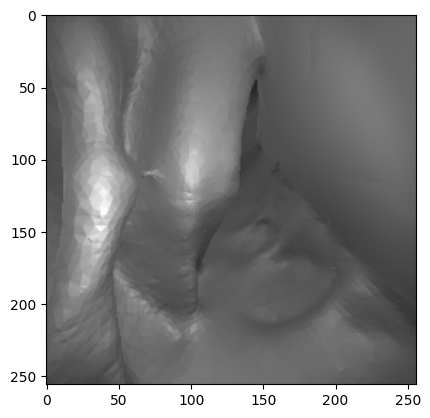

In [7]:
import imageio
import matplotlib.pyplot as plt

print(torch.rand(1).item())

img = load_as_float("/root/autodl-tmp/UCL/C_T1_L1_1_resized/FrameBuffer_0022.png")
print(img.shape)
r_img = img[0:1]
print(r_img.shape)
img = np.concatenate((r_img,r_img,r_img),axis=0)
print(img.shape)
plt.imshow(img.transpose((1,2,0)))

# img = imageio.imread("/root/autodl-tmp/UCL/C_T1_L1_1_resized/FrameBuffer_0022.png")
# plt.figure()
# plt.imshow(img)
# img_ = post_transform(image=img)
# plt.figure()
# plt.imshow(img_)

In [8]:

import datetime


args.name = '/root/autodl-tmp/SC_Depth_ckpts/pretrainDepth'

timestamp = datetime.datetime.now().strftime("%m-%d-%H:%M")
save_path = Path(args.name)
args.save_path = 'checkpoints'/save_path/timestamp
print('=> will save everything to {}'.format(args.save_path))
args.save_path.makedirs_p()


import time
import csv
from logger import TermLogger, AverageMeter
from tensorboardX import SummaryWriter
import torch.nn.functional as tnf

def compute_depth(disp_net, tgt_img):
    return [1/t for t in disp_net(tgt_img)]

def compute_loss(tgt_depths,gt):
    loss = 0
    factor = 1
    for i in range(len(tgt_depths)):
        tgt_depth = tgt_depths[i]
        gt_depth = tnf.interpolate(gt,scale_factor=(factor,factor))
        loss += (tgt_depth-gt_depth).norm()
        factor /= 2
    return loss/4

train_writer = SummaryWriter(args.save_path)
my_writers = {}
my_writers['depth_range'] = SummaryWriter(args.save_path/'mine_writer')
my_writers['rotation'] = SummaryWriter(args.save_path/'mine_writer')
my_writers['translation'] = SummaryWriter(args.save_path/'mine_writer')
def train(args, train_loader, disp_net,  optimizer, epoch_size, logger, train_writer):
    global n_iter, device
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter(precision=4)

    # switch to train mode
    disp_net.train()

    end = time.time()
    # logger.train_bar.update(0)

    for i, (tgt_img, depth) in enumerate(train_loader):
        log_losses = i > 0 and n_iter % args.print_freq == 0

        # tgt_img = tgt_img[::,0:1,...]
        # ref_imgs = [ref_img[::,0:1,...] for ref_img in ref_imgs]
        # measure data loading time
        data_time.update(time.time() - end)
        tgt_img = tgt_img.to(device)
        depth = depth.to(device)

        # compute output
        tgt_depths = compute_depth(disp_net, tgt_img)

        loss = compute_loss(tgt_depths,depth)

        tgt_depth = tgt_depths[0]
        if log_losses:
            train_writer.add_scalar('loss/total_loss', loss.item(), n_iter)
            
            my_writers['depth_range'].add_scalars('depth',
                                                  {'depth_max': tgt_depth[0].max().item(),
                                                   'depth_min': tgt_depth[0].min().item(),
                                                   'depth_mean': tgt_depth[0].mean().item()}, n_iter)

        # record loss and EPE
        losses.update(loss.item(), args.batch_size)

        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        with open(args.save_path/args.log_full, 'a') as csvfile:
            writer = csv.writer(csvfile, delimiter='\t')
            writer.writerow([loss.item()])
        # logger.train_bar.update(i+1)
        # if i % args.print_freq == 0:
        #     logger.train_writer.write('Train: Time {} Data {} Loss {}'.format(batch_time, data_time, losses))
        # if i >= epoch_size - 1:
        #     break

        n_iter += 1

    return losses.avg[0]

=> will save everything to /root/autodl-tmp/SC_Depth_ckpts/pretrainDepth/10-13-03:18


In [9]:


import shutil
import numpy as np
import torch
from path import Path
import datetime
from collections import OrderedDict
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


def high_res_colormap(low_res_cmap, resolution=1000, max_value=1):
    # Construct the list colormap, with interpolated values for higer resolution
    # For a linear segmented colormap, you can just specify the number of point in
    # cm.get_cmap(name, lutsize) with the parameter lutsize
    x = np.linspace(0, 1, low_res_cmap.N)
    low_res = low_res_cmap(x)
    new_x = np.linspace(0, max_value, resolution)
    high_res = np.stack([np.interp(new_x, x, low_res[:, i])
                         for i in range(low_res.shape[1])], axis=1)
    return ListedColormap(high_res)


def opencv_rainbow(resolution=1000):
    # Construct the opencv equivalent of Rainbow
    opencv_rainbow_data = (
        (0.000, (1.00, 0.00, 0.00)),
        (0.400, (1.00, 1.00, 0.00)),
        (0.600, (0.00, 1.00, 0.00)),
        (0.800, (0.00, 0.00, 1.00)),
        (1.000, (0.60, 0.00, 1.00))
    )

    return LinearSegmentedColormap.from_list('opencv_rainbow', opencv_rainbow_data, resolution)


COLORMAPS = {'rainbow': opencv_rainbow(),
             'magma': high_res_colormap(cm.get_cmap('magma')),
             'bone': cm.get_cmap('bone', 10000)}

def tensor2array(tensor, max_value=None, colormap='rainbow'):
    tensor = tensor.detach().cpu()
    if max_value is None:
        max_value = tensor.max().item()
    if tensor.ndimension() == 2 or tensor.size(0) == 1:
        norm_array = tensor.squeeze().numpy()/max_value
        array = COLORMAPS[colormap](norm_array).astype(np.float32)
        array = array.transpose(2, 0, 1)

    elif tensor.ndimension() == 3:
        assert(tensor.size(0) == 3)
        array = tensor.numpy()
    return array


@torch.no_grad()
def validate_with_gt(args, val_loader, disp_net, epoch, logger, output_writers=[]):
    global device
    batch_time = AverageMeter()
    
    log_outputs = len(output_writers) > 0

    # switch to evaluate mode
    disp_net.eval()

    end = time.time()
    # logger.valid_bar.update(0)
    for i, (tgt_img, depth) in enumerate(val_loader):
        tgt_img = tgt_img.to(device)
        depth = depth.to(device)

        # check gt
        if depth.nelement() == 0:
            continue

        # compute output
        output_disp = disp_net(tgt_img)
        output_depth = 1/output_disp[0]

        if log_outputs and i < len(output_writers):
            if epoch == 0:
                output_writers[i].add_image('val Input', tensor2array(tgt_img[0]), 0)
                depth_to_show = depth[0]
                output_writers[i].add_image('val target Depth',
                                            tensor2array(depth_to_show, max_value=None),
                                            epoch)
                depth_to_show[depth_to_show == 0] = 1000
                disp_to_show = (1/depth_to_show).clamp(0, 10)
                output_writers[i].add_image('val target Disparity Normalized',
                                            tensor2array(disp_to_show, max_value=None, colormap='magma'),
                                            epoch)

            output_writers[i].add_image('val Dispnet Output Normalized',
                                        tensor2array(output_disp[0], max_value=None, colormap='magma'),
                                        epoch)
            output_writers[i].add_image('val Depth Output',
                                        tensor2array(output_depth[0], max_value=None),
                                        epoch)

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
    #     logger.valid_bar.update(i+1)
    #     if i % args.print_freq == 0:
    #         logger.valid_writer.write('valid: Time {} Abs Error {:.4f} ({:.4f})'.format(batch_time, 1, 1))
    # logger.valid_bar.update(len(val_loader))
    return


In [10]:

from logger import TermLogger
import csv
from tqdm import tqdm

args.epochs = 100

def save_checkpoint(save_path, dispnet_state, is_best, filename='checkpoint.pth.tar'):
    file_prefixes = ['dispnet']
    states = [dispnet_state]
    for (prefix, state) in zip(file_prefixes, states):
        torch.save(state, save_path/'{}_{}'.format(prefix, filename))

    if is_best:
        for prefix in file_prefixes:
            shutil.copyfile(save_path/'{}_{}'.format(prefix, filename),
                            save_path/'{}_model_best.pth.tar'.format(prefix))


logger = TermLogger(n_epochs=args.epochs, train_size=min(len(train_loader), args.epoch_size), valid_size=len(val_loader))
# logger.epoch_bar.start()

output_writers = []
if args.log_output:
    for i in range(3):
        output_writers.append(SummaryWriter(args.save_path/'valid'/str(i)))

for epoch in tqdm(range(args.epochs)):
    
    # logger.reset_valid_bar()
    
    # logger.epoch_bar.update(epoch)
    
    # logger.reset_train_bar()
    train_loss = train(args, train_loader, disp_net,  optimizer, args.epoch_size, logger, train_writer)
    
    logger.train_writer.write(' * Avg Loss : {:.3f}'.format(train_loss))
    # evaluate on validation set
    # logger.reset_valid_bar()
    validate_with_gt(args,val_loader,disp_net,epoch,logger,output_writers)
    
    decisive_error = train_loss
    if best_error < 0:
        best_error = decisive_error
    # remember lowest error and save checkpoint
    is_best = decisive_error < best_error
    best_error = min(best_error, decisive_error)
    save_checkpoint(
        args.save_path, {
            'epoch': epoch + 1,
            'state_dict': disp_net.module.state_dict()
        }, is_best)
    
    with open(args.save_path/args.log_summary, 'a') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow([train_loss, decisive_error])
        
# logger.epoch_bar.finish()

  0%|          | 0/100 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


 * Avg Loss : 10059.660


  1%|          | 1/100 [00:10<17:55, 10.87s/it]

 * Avg Loss : 4881.289


  2%|▏         | 2/100 [00:25<20:36, 12.62s/it]


KeyboardInterrupt: 

(992, 1152, 3)
<class 'list'>


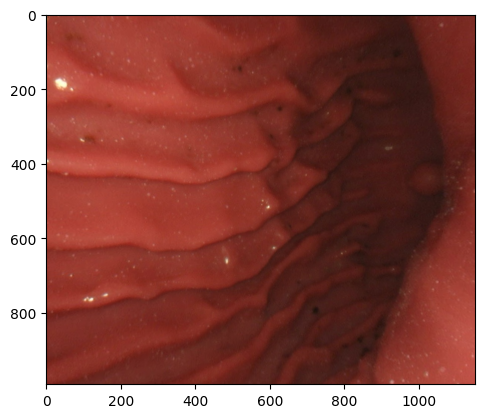

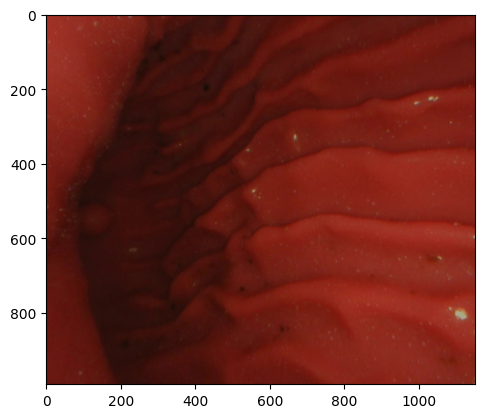

In [ ]:
from torchvision import transforms
from imgaug import augmenters as iaa
# 构建pipline
tfs =  iaa.Sequential([
        iaa.flip.Fliplr(p=0.5),
        iaa.flip.Flipud(p=0.5),
        iaa.MultiplyBrightness(mul=(0.65, 1.35)),
    ])
    # transforms.ToTensor()

import cv2
import matplotlib.pyplot as plt

img = cv2.imread("/root/autodl-tmp/dataset4SC_Depth/scene1_bkp/0002541.jpg")
img2 = cv2.imread("/root/autodl-tmp/dataset4SC_Depth/scene1_bkp/0002550.jpg")

# img = cv2.imread("/root/autodl-tmp/dataset4SC_Depth/scene1_bkp/0002541.jpg")
print(img.shape)

plt.figure()
plt.imshow(img[...,::-1])

plt.figure()
tt = tfs(images=[img,img2])
print(type(tt))
plt.imshow(tt[0][...,::-1])
